<a href="https://colab.research.google.com/github/NSR9/EVA8/blob/main/S4/Notebook_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NoteBook 3:-
##Target:

* Decrease in dropout from 0.1 to 0.05
* Random Rotation from (7,-7) to (10,-10)
* Change One Cycle Schedular to Step LR

## Results:
* Parameters: **7,228 (Less than 8000)**
* Best Train Accuracy: **98.81(14th Epoch)**
* Test Accuracy: **99.40(7th Epoch), Highest - 99.47(11th Epoch)**

## Analysis:
* After Test Accuracy achieved **99.40% at 7th Epoch never fell below 99.40% henceafter** maintaining the consistancy required.
* The difference in the train and test accuracy has decreased.

## Calling out to the GODS (Importing Libs):

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms



import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR,OneCycleLR
from sklearn.metrics import confusion_matrix

## Network Block :

#### Conv Block 1
* 2D Convolution number of kernels 8, followed with Batch Normalization and 2D Dropout of 0.05 
* 2D Convolution number of kernels 8, followed with Batch Normalization and 2D Dropout of 0.05

#### Transition Layer 1
* 2D Max Pooling to reduce the size of the channel to 12

#### Conv Block 2
* 2D Convolution number of kernels 10, followed with Batch Normalization and 2D Dropout of 0.05 
* 2D Convolution number of kernels 10, followed with Batch Normalization and 2D Dropout of 0.05 
* 2D Convolution number of kernels 10, followed with Batch Normalization and 2D Dropout of 0.05 
* 2D Convolution number of kernels 16, followed with Batch Normalization and 2D Dropout of 0.1
* 2D Convolution number of kernels 16, followed with Batch Normalization and 2D Dropout of 0.1

#### Global Average Pooling
* Global Average pooling with a size 6 and Padding 1 to return a 16 x 1 x 1 as output dimensions

#### Conv Block 3
* 2D Convolution number of kernels 10, followed with Batch Normalization and 2D Dropout of 0.1 


In [2]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        ##Conv Block 1
        self.conv_block1 = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, bias=False), #28, 28
              nn.ReLU(),
              nn.BatchNorm2d(8),
              nn.Dropout(dropout_value),

              nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1, bias=False), #28, 28
              nn.ReLU(),
              nn.BatchNorm2d(8),
              nn.Dropout(dropout_value),
        )

        ##Transition Block 1
        self.trans1 = nn.Sequential(
              nn.MaxPool2d(2, 2),#28, 14
        )

        ##Conv Block 2        
        self.conv_block2 = nn.Sequential(
              nn.Conv2d(in_channels=8, out_channels=10, kernel_size=3, padding=0, bias=False),#14, 12
              nn.ReLU(),
              nn.BatchNorm2d(10),
              nn.Dropout(dropout_value),

              nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=0, bias=False),#12, 10
              nn.ReLU(),
              nn.BatchNorm2d(10),
              nn.Dropout(dropout_value),

              nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=0, bias=False),#10, 8
              nn.ReLU(),
              nn.BatchNorm2d(10),
              nn.Dropout(dropout_value),
              
              nn.Conv2d(in_channels=10, out_channels=16, kernel_size=3, padding=0, bias=False),#8, 6
              nn.ReLU(),
              nn.BatchNorm2d(16),
              nn.Dropout(dropout_value),
              
              nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=0, bias=False),#6, 4
              nn.ReLU(),
              nn.BatchNorm2d(16),
              nn.Dropout(dropout_value),
        )

        ##Global Average Pooling
        self.gap = nn.Sequential(
              nn.AvgPool2d(kernel_size=6, stride=1, padding = 1),#6, 1
        ) 

        ##Conv Block 1
        self.conv_block3 = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),#1, 1
        )

    def forward(self, x):

        x =  self.conv_block1(x)
        x =  self.trans1(x)
        x =  self.conv_block2(x)
        x =  self.gap(x)
        x =  self.conv_block3(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(x)

##Model Summary:

#### Params used 7,228 (Less than 8000)

In [3]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
       BatchNorm2d-7            [-1, 8, 28, 28]              16
           Dropout-8            [-1, 8, 28, 28]               0
         MaxPool2d-9            [-1, 8, 14, 14]               0
           Conv2d-10           [-1, 10, 12, 12]             720
             ReLU-11           [-1, 10, 12, 12]               0
      BatchNorm2d-12           [-1, 10, 12, 12]              20
          Dropout-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1, 10,

<ipython-input-2-bbbdcc178c05>:70: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [4]:
model.eval()

Net(
  (conv_block1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.05, inplace=False)
    (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.05, inplace=False)
  )
  (trans1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(8, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.05, inplace=False)
    (4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True

## Image Augumentation

* Adding Random Rotation of (10,-10)

In [5]:
train_transforms =  transforms.Compose(
    [
    #  transforms.RandomResizedCrop(224),
    #  transforms.RandomAffine(degrees=10, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
     transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
    #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
     transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

# We Don't apply transformations on the Test Data

## Loading DataSet:


In [6]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=train_transforms),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



## Train Test Functions:

In [7]:
from tqdm import tqdm
actuals = []
predictions = []
wrong_images=[]
wrong_label=[]
correct_label=[]
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    processed = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        processed += len(data)
        pbar.set_description(desc= f'Epoch{epoch} : Loss={loss.item()}  Accuracy={100*correct/processed:0.2f} Batch_id={batch_idx}')
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader)
    train_acc = 100.00*correct/len(train_loader.dataset)
    return train_acc, train_loss

def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            if epoch == 15:
                actuals.extend(target.view_as(pred))
                predictions.extend(pred)
                wrong_pred = pred.eq(target.view_as(pred)) == False
                wrong_images.append(data[wrong_pred])
                wrong_label.append(pred[wrong_pred])
                correct_label.append(target.view_as(pred)[wrong_pred]) 

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc = 100.00 * correct / len(test_loader.dataset)
    return test_acc, test_loss


## Model Training:

In [13]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []

scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
# scheduler = OneCycleLR(optimizer, max_lr=0.01,epochs=15,steps_per_epoch=len(train_loader))

for epoch in range(1, 20):
    train_acc, train_loss = train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test_acc, test_loss = test(model, device, test_loader, epoch)

    train_accuracy_values.append(train_acc)
    train_loss_values.append(train_loss)

    test_accuracy_values.append(test_acc)
    test_loss_values.append(test_loss)

    


  0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-2-bbbdcc178c05>:70: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
Epoch1 : Loss=0.19866915047168732  Accuracy=83.44 Batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 23.06it/s]



Test set: Average loss: 0.0970, Accuracy: 9781/10000 (97.81%)



Epoch2 : Loss=0.178505077958107  Accuracy=97.13 Batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.85it/s]



Test set: Average loss: 0.0520, Accuracy: 9870/10000 (98.70%)



Epoch3 : Loss=0.06099693849682808  Accuracy=97.70 Batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.80it/s]



Test set: Average loss: 0.0405, Accuracy: 9891/10000 (98.91%)



Epoch4 : Loss=0.041738320142030716  Accuracy=97.97 Batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 23.07it/s]



Test set: Average loss: 0.0336, Accuracy: 9904/10000 (99.04%)



Epoch5 : Loss=0.12109624594449997  Accuracy=98.09 Batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.67it/s]



Test set: Average loss: 0.0332, Accuracy: 9903/10000 (99.03%)



Epoch6 : Loss=0.04045925661921501  Accuracy=98.27 Batch_id=468: 100%|██████████| 469/469 [00:21<00:00, 22.31it/s]



Test set: Average loss: 0.0254, Accuracy: 9925/10000 (99.25%)



Epoch7 : Loss=0.08622000366449356  Accuracy=98.52 Batch_id=468: 100%|██████████| 469/469 [00:21<00:00, 21.56it/s]



Test set: Average loss: 0.0228, Accuracy: 9938/10000 (99.38%)



Epoch8 : Loss=0.02999991364777088  Accuracy=98.61 Batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.58it/s]



Test set: Average loss: 0.0223, Accuracy: 9931/10000 (99.31%)



Epoch9 : Loss=0.02057088352739811  Accuracy=98.65 Batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.62it/s]



Test set: Average loss: 0.0218, Accuracy: 9935/10000 (99.35%)



Epoch10 : Loss=0.0549580417573452  Accuracy=98.60 Batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 23.04it/s]



Test set: Average loss: 0.0216, Accuracy: 9938/10000 (99.38%)



Epoch11 : Loss=0.04271766170859337  Accuracy=98.61 Batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.54it/s]



Test set: Average loss: 0.0216, Accuracy: 9940/10000 (99.40%)



Epoch12 : Loss=0.018340855836868286  Accuracy=98.66 Batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.80it/s]



Test set: Average loss: 0.0221, Accuracy: 9931/10000 (99.31%)



Epoch13 : Loss=0.026749903336167336  Accuracy=98.64 Batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.68it/s]



Test set: Average loss: 0.0211, Accuracy: 9936/10000 (99.36%)



Epoch14 : Loss=0.017289668321609497  Accuracy=98.73 Batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.80it/s]



Test set: Average loss: 0.0208, Accuracy: 9937/10000 (99.37%)



Epoch15 : Loss=0.038884490728378296  Accuracy=98.69 Batch_id=468: 100%|██████████| 469/469 [00:21<00:00, 21.81it/s]



Test set: Average loss: 0.0206, Accuracy: 9938/10000 (99.38%)



Epoch16 : Loss=0.063925601541996  Accuracy=98.70 Batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 23.03it/s]



Test set: Average loss: 0.0209, Accuracy: 9938/10000 (99.38%)



Epoch17 : Loss=0.07100596278905869  Accuracy=98.68 Batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.48it/s]



Test set: Average loss: 0.0209, Accuracy: 9939/10000 (99.39%)



Epoch18 : Loss=0.016464291140437126  Accuracy=98.77 Batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.58it/s]



Test set: Average loss: 0.0207, Accuracy: 9941/10000 (99.41%)



Epoch19 : Loss=0.044668663293123245  Accuracy=98.73 Batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.95it/s]



Test set: Average loss: 0.0208, Accuracy: 9935/10000 (99.35%)



## Confusion Matrix

Confusion matrix:


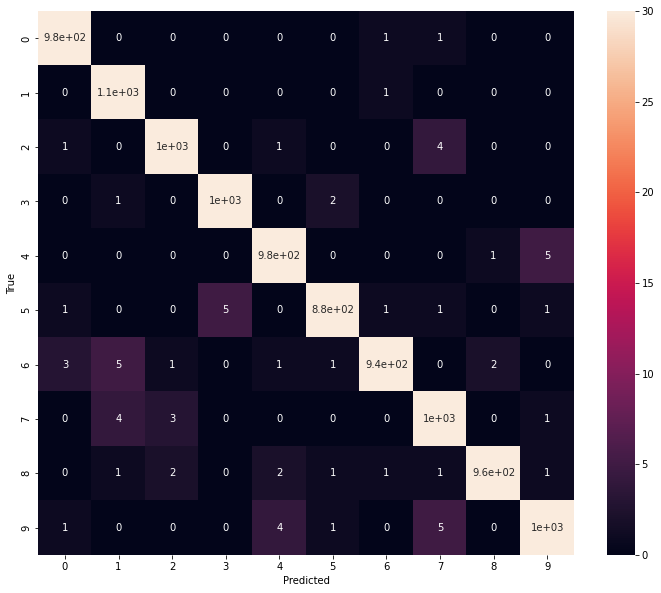

In [9]:
actuals = [i.item() for i in actuals]
predictions = [i.item() for i in predictions]

conf_mat = confusion_matrix(actuals, predictions)
print('Confusion matrix:')
plt.subplots(figsize=(12,10))
ax = sns.heatmap(conf_mat, annot=True, vmax=30)
ax.set_xlabel('Predicted');
ax.set_ylabel('True');

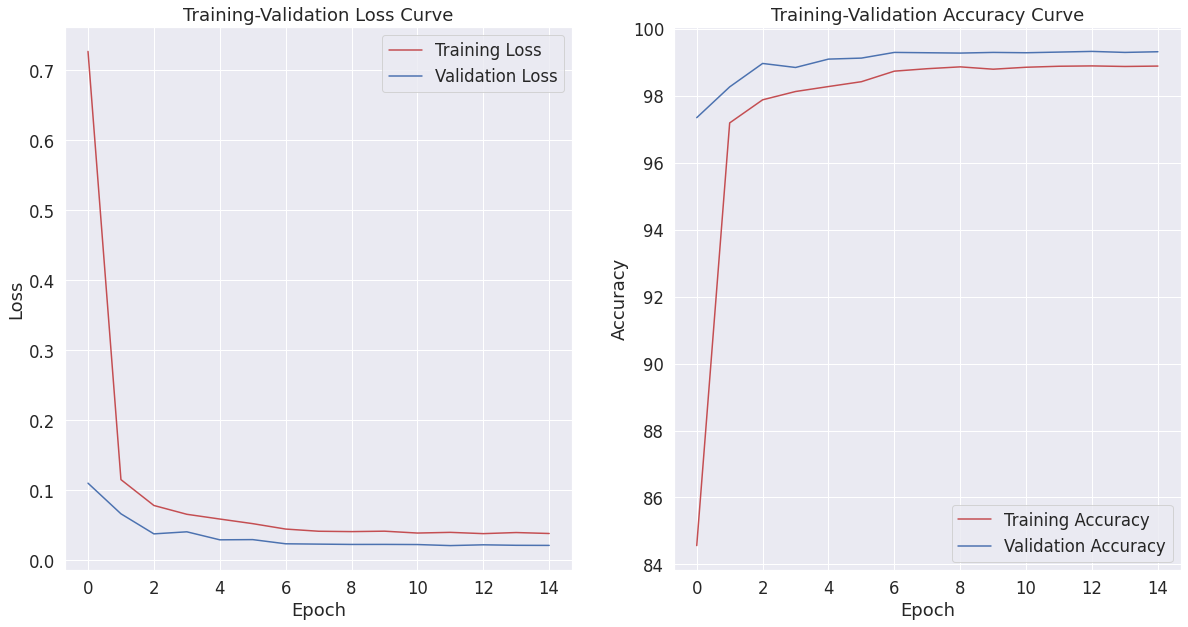

In [10]:
sns.set(style='whitegrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (20,10)

# Plot the learning curve.
fig, (plt1,plt2) = plt.subplots(1,2)
plt1.plot(np.array(train_loss_values), 'r', label="Training Loss")
plt1.plot(np.array(test_loss_values), 'b', label="Validation Loss")
plt2.plot(np.array(train_accuracy_values), 'r', label="Training Accuracy")
plt2.plot(np.array(test_accuracy_values), 'b', label="Validation Accuracy")

plt2.set_title("Training-Validation Accuracy Curve")
plt2.set_xlabel("Epoch")
plt2.set_ylabel("Accuracy")
plt2.legend()
plt1.set_title("Training-Validation Loss Curve")
plt1.set_xlabel("Epoch")
plt1.set_ylabel("Loss")
plt1.legend()

plt.show()

Number of wrongly predicted images 79


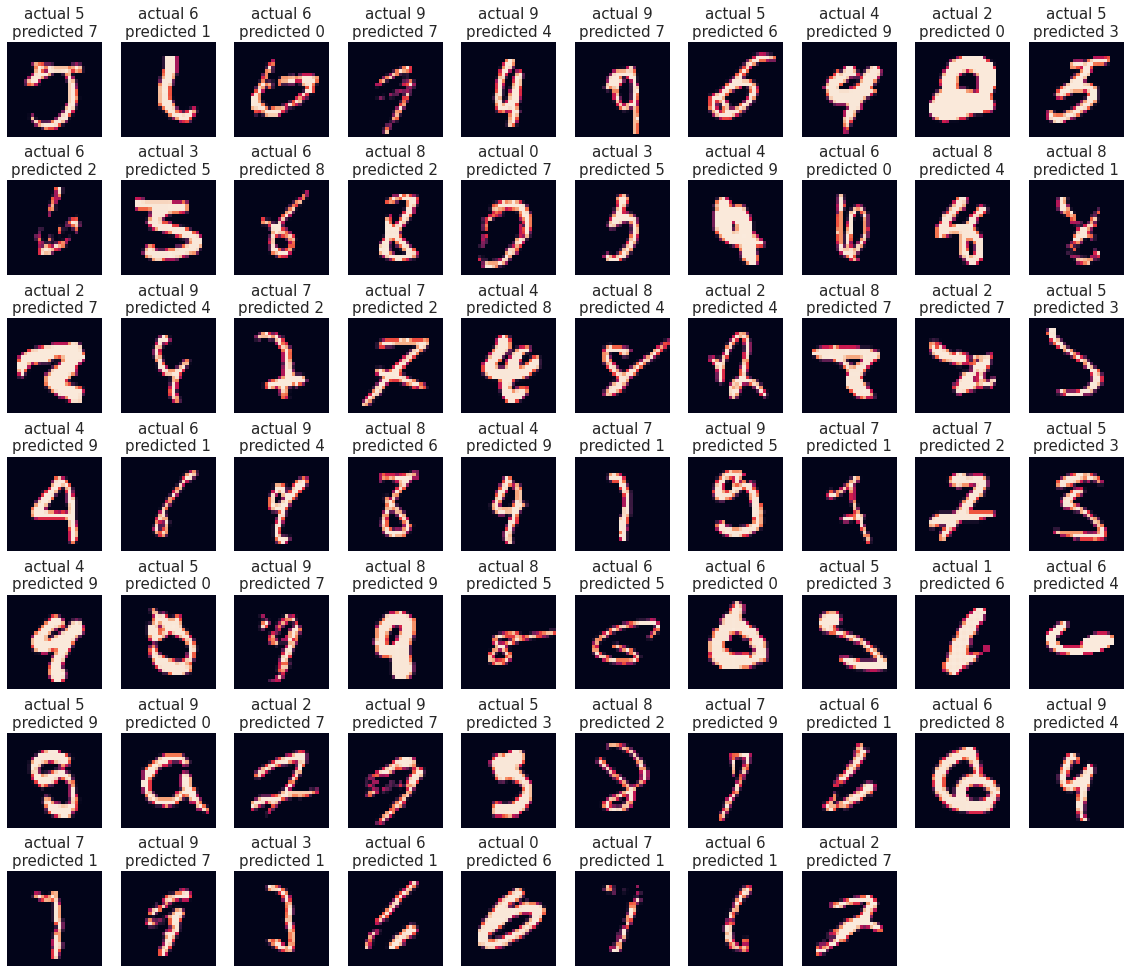

In [11]:
print(f"Number of wrongly predicted images {len(wrong_images)}")
fig = plt.figure(figsize=(20,25))
for i, (img, pred, correct) in enumerate(zip(torch.cat(wrong_images),torch.cat(wrong_label), torch.cat(correct_label))):
    img = img.cpu().numpy()
    pred = pred.cpu()
    target = correct.cpu()
    ax = fig.add_subplot(10, 10, i+1)
    ax.axis('off')
    ax.set_title(f'actual {target.item()}\npredicted {pred.item()}',fontsize=15)
    ax.imshow(img.squeeze())